Pada proyek Neural Network (**LSTM**) kali ini kami menggunakan data sekunder dengan nama "**train_preprocess.tsv.txt**" yang terdiri dari 2 kolom (**tweet dan label**) berisi data tweet dan analisa sentimennya (positif, negatif, dan netral)

# **Prepare datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset from database
import pandas as pd

# Tentukan path file TSV
tsv_path = '/content/drive/MyDrive/Colab Notebooks/Platinum/train_preprocess.tsv.txt'

# Definisikan nama kolom
column_names = ['tweet', 'label']

# Baca data dari file TSV ke DataFrame dengan menambahkan nama kolom
df = pd.read_csv(tsv_path, sep='\t', names=column_names)

# **EDA**

Membaca dan melakukan visualisasi data

In [ ]:
# Tampilkan data

df.head()

,tweet,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [ ]:
# Mengecek Kolom dan Baris

df.shape

(11000, 2)

In [ ]:
# Missing value check

df.isna().sum()

tweet    0
label    0
dtype: int64

In [ ]:
# Melihat Perbandingan data berdasarkan label
df['label'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [ ]:
# Membaca Duplikasi Data

df.duplicated(subset='tweet').sum()

67

In [ ]:
# Menghapus duplikat pada kolom "tweet"
df = df.drop_duplicates(subset='tweet')

# Memeriksa data setelah menghapus duplikat
print("\nData setelah menghapus duplikat:")
print(df)


Data setelah menghapus duplikat:
                                                   tweet     label
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
10993  f - demokrat dorong upaya kemandirian energi n...   neutral
10994                                        tidak bosan  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10998  pagi pagi di tol pasteur sudah macet parah , b...  negative
10999  meskipun sering belanja ke yogya di riau junct...  positive

[10933 rows x 2 columns]


In [ ]:
# Mengecek Kolom dan Baris

df.shape

(10933, 2)

In [ ]:
# Melihat Perbandingan data berdasarkan label
df['label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: label, dtype: int64

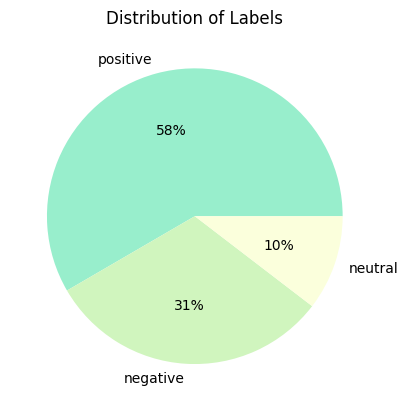

In [ ]:
# Visualisasi dengan pie chart

df.label.value_counts().plot.pie(autopct='%1.0f%%', colors = ['#98EECC', '#D0F5BE', '#FBFFDC'])
plt.title('Distribution of Labels')
plt.axis('off')
plt.show()

In [ ]:
# Membuat kolom baru bernama total_word yang bersumber dari banyak kata pada kolom tweet

df['total_word'] = df['tweet'].apply(lambda word: len(word.split()))

# Menampilkan kolom

df.head()

,tweet,label,total_word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


In [ ]:
# Menampilkan ringkasan statistik dari karakteristik data

df.describe()

,total_word
count,10933.000000
mean,33.060551
std,21.141323
min,1.000000
25%,16.000000
50%,28.000000
75%,48.000000
max,110.000000


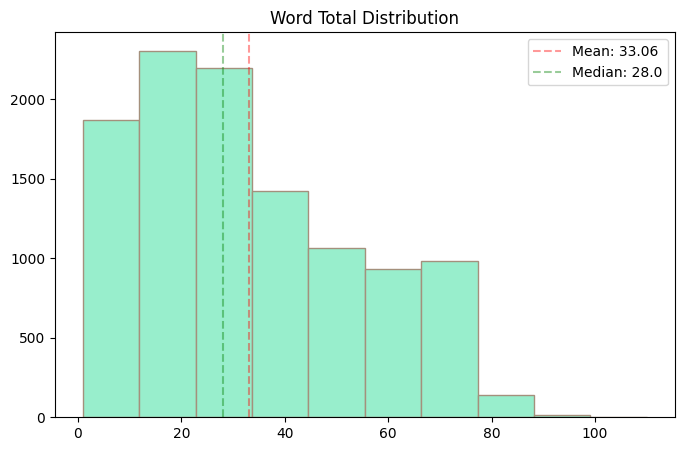

In [ ]:
# Data distribution visualization

fig = plt.figure(figsize=(8, 5))
plt.hist(df['total_word'], color='#98EECC', edgecolor='#A4907C')
plt.axvline(x=df['total_word'].mean(), ls='--', color='red', alpha=0.4, label=f'Mean: {round(df["total_word"].mean(), 2)}')
plt.axvline(x=df['total_word'].median(), ls='--', color='green', alpha=0.4, label=f'Median: {round(df["total_word"].median(), 2)}')
plt.title('Word Total Distribution', size=12)
plt.legend()
plt.show()

# **Text Normalization/Cleansing**

Lalu kita lakukan cleansing sebagai berikut

In [ ]:
!pip install --upgrade Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00


In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()

    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', string)
    string = re.sub(r'https://t.co/\w+', ' ', string)
    string = re.sub('\n', ' ', string)
    string = re.sub('rt', ' ', string)
    string = re.sub('  +', ' ', string)
    string = re.sub(r'pic.twitter.com.[\w]+', '', string)
    string = re.sub('user', ' ', string)
    string = re.sub(r"\bx\w{2}\b", "", string)
    string = re.sub(r'‚Ä¶', '', string)
    string = re.sub('[^0-9a-zA-Z]+', ' ', string)

    # Lematisasi menggunakan Sastrawi
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    string = stemmer.stem(string)

    # Menghapus stop words menggunakan Sastrawi
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    string = stopword_remover.remove(string)

    return string

In [ ]:
# Mengaplikasikan fungsi cleansing pada kolom "tweet" dan menyimpan hasilnya di kolom "text_clean"
#df['tweet_clean'] = df.tweet.apply(cleansing)

from tqdm import tqdm  # Import tqdm


# Menggunakan tqdm untuk menampilkan progres
tqdm.pandas()

# Melakukan pembersihan teks pada kolom "tweet" dan menyimpan hasilnya di kolom "tweet_clean"
df['tweet_clean'] = df['tweet'].progress_apply(cleansing)

100%|██████████| 10933/10933 [1:30:29<00:00,  2.01it/s]


In [ ]:
df.head()

,tweet,label,tweet_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik tahu sudah puluh tah...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah pa ai apa ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung tempat...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri saat unboxing paket ba...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


Sortir data dan label berdasarkan sentimen

In [ ]:
neg = df.loc[df['label'] == 'negative'].tweet_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].tweet_clean.tolist()
pos = df.loc[df['label'] == 'positive'].tweet_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [ ]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


# **Feature Extraction**

Setelah itu kita lakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow.

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split

file = open("/content/drive/MyDrive/Colab Notebooks/Platinum/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("/content/drive/MyDrive/Colab Notebooks/Platinum/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# **Training**

Jalankan training dengan metode LSTM. Arsitektur LSTM ini dibangun menggunakan framework Tensorflow.

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur LSTM yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100.
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [ ]:
embed_dim = 100
units = 64
max_features = 100000

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 89, 100)           10000000  
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
875/875 [==============================] - 285s 284ms/step - loss: 0.4761 - accuracy: 0.8095 - val_loss: 0.3421 - val_accuracy: 0.8701
Epoch 2/10
875/875 [==============================] - 247s 282ms/step - loss: 0.2451 - accuracy: 0.9094 - val_loss: 0.3383 - val_accuracy: 0.8747
Epoch 3/1

# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [ ]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 20ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       681
           1       0.76      0.76      0.76       235
           2       0.88      0.94      0.91      1271

    accuracy                           0.87      2187
   macro avg       0.84      0.82      0.83      2187
weighted avg       0.87      0.87      0.86      2187



Hasilnya nilai F1 Score ada pada angka 0.81 untuk Negative, 0.76 untuk Neutral, dan 0.91 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model, dengan nilai accuracy 0,87 (87%)                           

## Visualization

Mekanisme evaluasi selanjutnya menggunakan "Visualization", yaitu mengecek performa training dari arah visualisasinya. Acuan apakah visualisasi bagus atau tidak "Good Fit", sebagai berikut:

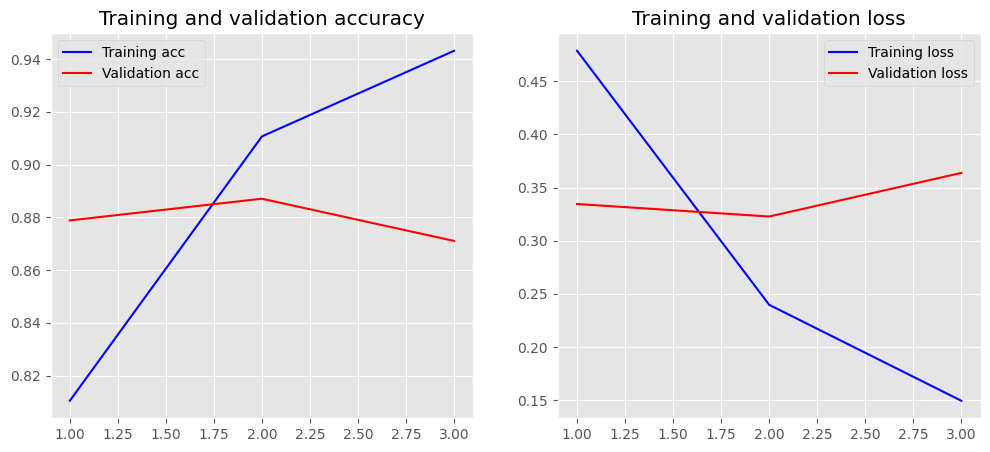

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Underfitting. Disinyalir karena:


*   Data training terlalu sedikit
*   Proses training berhenti terlalu cepat. Mungkin saja penerapan EarlyStopping untuk kasus kita tidak terlalu tepat


Grafik ini tidak digunakan, karena has

In [ ]:
model.save('model.h5')
print("Model has created!")

Model has created!


# Predict

In [ ]:
import re
from keras.models import load_model
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

input_text = """
Rasa bersyukur, cukup.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()

    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', string)
    string = re.sub(r'https://t.co/\w+', ' ', string)
    string = re.sub('\n', ' ', string)
    string = re.sub('rt', ' ', string)
    string = re.sub('  +', ' ', string)
    string = re.sub(r'pic.twitter.com.[\w]+', '', string)
    string = re.sub('user', ' ', string)
    string = re.sub(r"\bx\w{2}\b", "", string)
    string = re.sub(r'‚Ä¶', '', string)
    string = re.sub('[^0-9a-zA-Z]+', ' ', string)

    # Lematisasi menggunakan Sastrawi
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    string = stemmer.stem(string)

    # Menghapus stop words menggunakan Sastrawi
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    string = stopword_remover.remove(string)

    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 507ms/step
Text:  rasa syukur cukup
Sentiment:  positive


In [ ]:
import re
from keras.models import load_model
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

input_text = """
Hari ini udara panas sekali
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()

    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', string)
    string = re.sub(r'https://t.co/\w+', ' ', string)
    string = re.sub('\n', ' ', string)
    string = re.sub('rt', ' ', string)
    string = re.sub('  +', ' ', string)
    string = re.sub(r'pic.twitter.com.[\w]+', '', string)
    string = re.sub('user', ' ', string)
    string = re.sub(r"\bx\w{2}\b", "", string)
    string = re.sub(r'‚Ä¶', '', string)
    string = re.sub('[^0-9a-zA-Z]+', ' ', string)

    # Lematisasi menggunakan Sastrawi
    stemmer_factory = StemmerFactory()
    stemmer = stemmer_factory.create_stemmer()
    string = stemmer.stem(string)

    # Menghapus stop words menggunakan Sastrawi
    stopword_factory = StopWordRemoverFactory()
    stopword_remover = stopword_factory.create_stop_word_remover()
    string = stopword_remover.remove(string)

    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 442ms/step
Text:  hari udara panas sekali
Sentiment:  negative
